In [1]:
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

## Changing directory to top folder (All programs run from top)
import os
os.chdir('/Users/nschumacher/docs/galvanize/smunch-user-food-analysis')

## local run sql file
from db.python_db import connect, run_sql_query

%matplotlib inline  
%config InlineBackend.figure_format='retina'

def get_rows(meals, ing_ids):

    ## Getting list of list of ingredients in meal
    ingr_l = []
    for meal in meals:

        Q = '''
        SELECT ingredient_ids
        FROM noah.meal_rating_ingredients
        WHERE meal_id='%s' '''%meal

        df = run_sql_query(Q, conn )
        ingr_l.append(df.values[0][0])

    ## converting each meal to feature space row
    rows  = []
    for ings in ingr_l:
        rows.append( np.array([ing in ings for ing in ing_ids]).astype(int) )

    return np.vstack(rows)


## Predicting meal consistency for all users
def get_preds(objs, rows):

    rf_preds = []
    gb_preds = []
    for key in objs.keys():
        u = objs[key]

        rf_preds.append(u.rf_model.predict(rows))
        gb_preds.append(u.gb_model.predict(rows))

    return (rf_preds, gb_preds)


## Getting user base breakdown
def user_percent(preds, n_m):
    counts = np.zeros(n_m)
    for i in range(len(preds)):
        sorts = np.argsort(preds[i])
        counts[sorts[-1]] += 1
    return np.round(np.array(counts)/sum(counts), 3)


def get_score(meals, user_objs, ing_ids, real):
    rows = get_rows(meals, ing_ids)
    rf_preds, gb_preds = get_preds(user_objs, rows)

    rf_percents = user_percent(rf_preds, 4)
    gb_percents = user_percent(gb_preds, 4)
    real_p = np.round(real/real.sum(), 3)

#     print("RF Meal Percents:", rf_percents)
#     print("GB Meal Percents:", gb_percents)
#     print("\nAc Meal Percents:", real_p)

    rf_error = np.round(np.mean(np.abs((rf_percents - real_p))),3)
    gb_error = np.round(np.mean(np.abs((gb_percents - real_p))),3)
    avg_error = np.round(np.mean(np.abs((.25 - real_p))),3)
#     print("\nRF error: ", rf_error)
#     print("GB error: ", gb_error)
#     print("Avg error:", avg_error)

    return ([rf_error, gb_error, avg_error], [rf_percents, gb_percents, real_p])

In [2]:
## Plot scatter of percents for each meal in group
def plot_ps(rfp, gbp, avgp):

    meal_g_length = len(rfps)
    for i in range(4):
        plt.scatter(meal_g_length, rfp[i], label="Meal {0}".format(i))

    plt.show()

In [3]:
def plot_avgs(avg_rf_perror, avg_gb_perror, avg_perror, means):

    meal_num = np.arange(len(avg_rf_perror))
    plt.plot(meal_num, avg_rf_perror, color='b', label="RF '%' Error")
    plt.plot(meal_num, avg_gb_perror, color='r', label="GB '%' Error")
    plt.plot(meal_num, avg_perror, color='g', label=".25 '%' Error")


    plt.hlines(means[0], 0, len(meal_num), color='b', linestyle='--', label='RF mean: {0:1.3f}'.format(means[0]))
    plt.hlines(means[1], 0, len(meal_num), color='r', linestyle='--', label='GB mean: {0:1.3f}'.format(means[1]))
    plt.hlines(means[2], 0, len(meal_num), color='g', linestyle='--', label='Avg mean: {0:1.3f}'.format(means[2]))

    plt.xlabel("Meal Group #")
    plt.ylabel("Avg '%' Error in Customer Base breakdown. ")
    plt.grid()
    plt.legend()
    plt.title("Model Erros of Customer '%' Breakdown")
    plt.show()

In [4]:
conn = connect()

ing_df = pd.read_csv('data/ingrds.csv')
user_objs = pickle.load(open('order_prediction/user_objects_test_dict.p', 'rb'))

ing_dict = dict(zip(ing_df.ingredient_id, ing_df.name))
ing_ids = list(ing_dict.keys())
ing_names = list(ing_dict.values())


meal_groups = [['a050N00000zZg6AQAS','a050N00000zZg6BQAS','a050N00000zZgH1QAK','a050N00000zZgH5QAK'],
               ['a050N00000za4nlQAA','a050N00000za4nqQAA','a050N00000za4nvQAA','a050N00000za4o5QAA'],
               ['a050N000010W5ezQAC','a050N00000zZfyqQAC','a050N00000zZfyrQAC','a050N000010W5eyQAC'],
               ['a050N00000zbFdeQAE','a050N00000zbGCDQA2','a050N00000zbFdjQAE','a050N00000zbFdZQAU'],
               ['a050N00000zZgH2QAK','a050N00000zZgH4QAK','a050N00000zZgH3QAK','a050N00000zZgH7QAK'],
               ['a050N00000zbES4QAM','a050N00000zbESJQA2','a050N00000zZfz8QAC','a050N00000zbESEQA2'],
               ['a050N00000zZg5LQAS','a050N00000zZg5MQAS','a050N000010W5f1QAC','a050N000010W5f2QAC'],
               ['a050N000013OpNUQA0','a050N000010WrWZQA0','a050N000010WrWAQA0','a050N000010WrWKQA0'],
               ['a050N000010XyHYQA0','a050N000016uz5iQAA','a050N000010XyHCQA0','a050N000016uz5EQAQ'],
               ['a050N000014zW24QAE','a050N00001C0K0fQAF','a050N00001C0K7rQAF','a050N000014zW1aQAE'],
               ['a050N000010W5f8QAC','a050N000010W5f7QAC','a050N000010W5fAQAS','a050N000010W5f9QAC'],
               ['a050N00000zbES4QAM','a050N00000zbESJQA2','a050N00000zZfz8QAC','a050N00000zbESEQA2'],
               ['a050N00000zZg8AQAS','a050N000010WMcmQAG','a050N00000zZg8BQAS','a050N000010WMcrQAG']]

real_ps_group = [np.array([26,23,16,10]), np.array([14,39,23,22]), np.array([42,26,47,71]),
                 np.array([49,50,77,23]), np.array([25,6,14,30]), np.array([19,26,33,81]),
                 np.array([71,21,13,5]), np.array([16,31,20,34]), np.array([25,38,43,15]),
                 np.array([41,47,18,15]), np.array([40,28,10,8]), np.array([21,56,54,104]),
                 np.array([71,40,56,28])]



rfp_vals, gbp_vals, realp_vals = [],[],[]
avg_rf_perror, avg_gb_perror, avg_perror = [],[],[]
rf_resids, gb_resids, base_resids = [], [], []

for i in range(len(meal_groups)):
    #print("Set:", i)
    ers, ps = get_score(meal_groups[i], user_objs, ing_ids, real_ps_group[i])

    rfp_vals.append(ps[0])
    gbp_vals.append(ps[1])
    realp_vals.append(ps[2])

    avg_rf_perror.append(ers[0])
    avg_gb_perror.append(ers[1])
    avg_perror.append(ers[2])
    
    rf_resids.append(np.abs(ps[0]-ps[2]))
    gb_resids.append(np.abs(ps[1]-ps[2]))
    base_resids.append(np.abs(.25-ps[2]))
                     



print("\n----------------\nFINAL AVG ERRORS:")
means = [np.round(np.mean(avg_rf_perror), 3),
         np.round(np.mean(avg_gb_perror), 3),
         np.round(np.mean(avg_perror), 3)]

print("RF error:", means[0])
print("GB error:", means[1])
print("Avg error:", means[2])


----------------
FINAL AVG ERRORS:
RF error: 0.077
GB error: 0.165
Avg error: 0.101


In [17]:
## Converting residual information into dictionary for Swarm Plot

ll = ['Random Forest']*len(rf_resids*4) + ['Gradient Boosted']*len(rf_resids*4) + ['Base (.25)']*len(rf_resids*4)
meals = [1,2,3,4]*(len(rf_resids)*3)

rf_rs = list(np.array(np.matrix(rf_resids).ravel())[0])
gb_rs = list(np.array(np.matrix(gb_resids).ravel())[0])
base_rs = list(np.array(np.matrix(base_resids).ravel())[0])

rs = rf_rs + gb_rs + base_rs

d = {'Model':ll, 'Residual':rs, 'Meal':meals}
df = pd.DataFrame(d)
df.sample(4)

,Meal,Model,Residual
0,1,Random Forest,0.042
78,3,Gradient Boosted,0.062
82,3,Gradient Boosted,0.006
69,2,Gradient Boosted,0.043


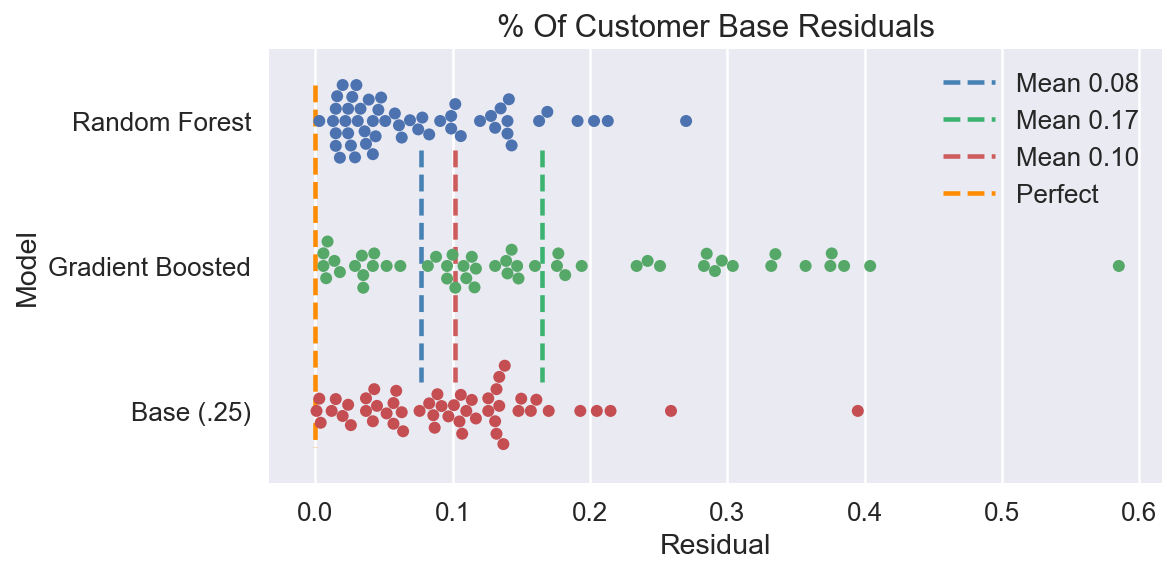

In [47]:
plt.figure(figsize=(8,4))
sns.set_context("talk")
sns.swarmplot(x="Residual", y="Model", data=df, size=6)

plt.vlines(np.mean(rf_rs), .2, 1.8, linestyles='--', color='steelblue', label="Mean {0:.2f}".format(np.mean(rf_rs)))
plt.vlines(np.mean(gb_rs), .2, 1.8, linestyles='--', color='mediumseagreen', label="Mean {0:.2f}".format(np.mean(gb_rs)))
plt.vlines(np.mean(base_rs), .2, 1.8, linestyles='--', color='indianred', label="Mean {0:.2f}".format(np.mean(base_rs)))
plt.vlines(0, -.25, 2.25, linestyles='--', color='darkorange', label="Perfect")


plt.title("% Of Customer Base Residuals")
plt.legend()